# Prescription Parser

We are gonna extract some meaningful information from medical prescription which is available in pdf files.
- Step 1: Convert pdf to image using **pdf2image** library
- Step 2: Preprocess the image (Apply **adaptive thresholding using OpenCV2**)
- Step 3: Extracting text from image by passing it through **tesseract OCR engine**
- Step 4: Finding useful information from text using **RegEx**

In [1]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint

In [2]:
!apt-get install -y poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
!pip install pytesseract pdf2image

In [4]:
# Install system packages
!apt-get install -y poppler-utils tesseract-ocr

# Install Python packages
!pip install pytesseract pdf2image

# Import required libraries
import pytesseract
from pdf2image import convert_from_path
import os

# Upload the PDF file
from google.colab import files
uploaded = files.upload()

# Get the name of the uploaded file
file_name = next(iter(uploaded))

# Convert PDF to images
images = convert_from_path(file_name)

# Set Tesseract path explicitly for Linux
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract' # Tells pytesseract where to find the tesseract executable on Linux

# Perform OCR on each image
for i, image in enumerate(images):
    text = pytesseract.image_to_string(image)
    print(f"Page {i+1}")
    print(text)
    print("\n" + "="*100 + "\n")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Saving download.pdf to download (1).pdf
Page 1
Image converted from PDF

Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Maria Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

K

Prednisone 20 ma
Lialda 2.4 gram

 





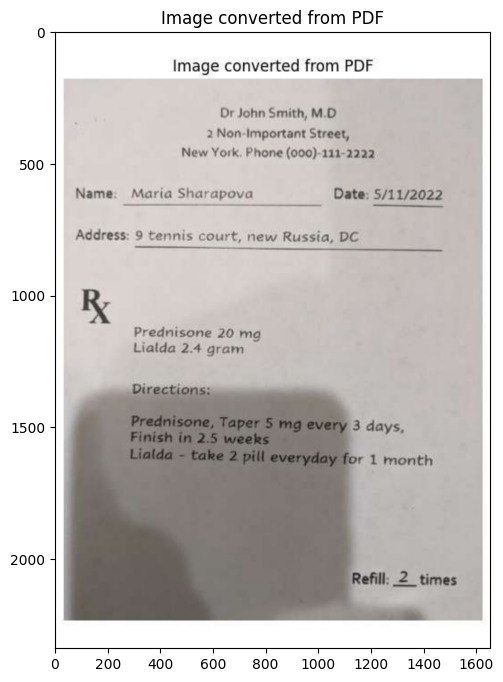

In [5]:
# Lets visualize our image
# pages[0].show() -> this PIL show() function opens image in a new window
plt.figure(figsize=(6,8))
plt.imshow(images[0])
plt.axis(True)
plt.title("Image converted from PDF")
plt.show()

🔎 **Observation:** Pytesseract couldn't extract text under the shadow in our image. Also a long unknown string after address.

💡 **Solution:** Apply image thresholding using OpenCV2 (ref: [cv2 documentation](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))

Types of thresholding:
1) Simple Thresholding:
> For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. The function `cv.threshold` is used to apply the thresholding.

2) Adaptive Thresholding:
> In simple thresholding, we use one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel based on a small region around it. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination.

**We will use adaptive thresholding**

In [6]:
import cv2
import numpy as np

# Assuming 'image' is the PIL image you want to process
gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)  # Convert color image to grayscale
resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)  # Upsize the image
processed_image = cv2.adaptiveThreshold(
    resized,  # our resized image
    255,  # max pixel value
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive thresholding
    cv2.THRESH_BINARY,  # convert to binary (black/white)
    63,  # block size (after trial and error)
    12  # constant (after trial and error)
)
print(processed_image) # Print the processed image, not image_processed

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


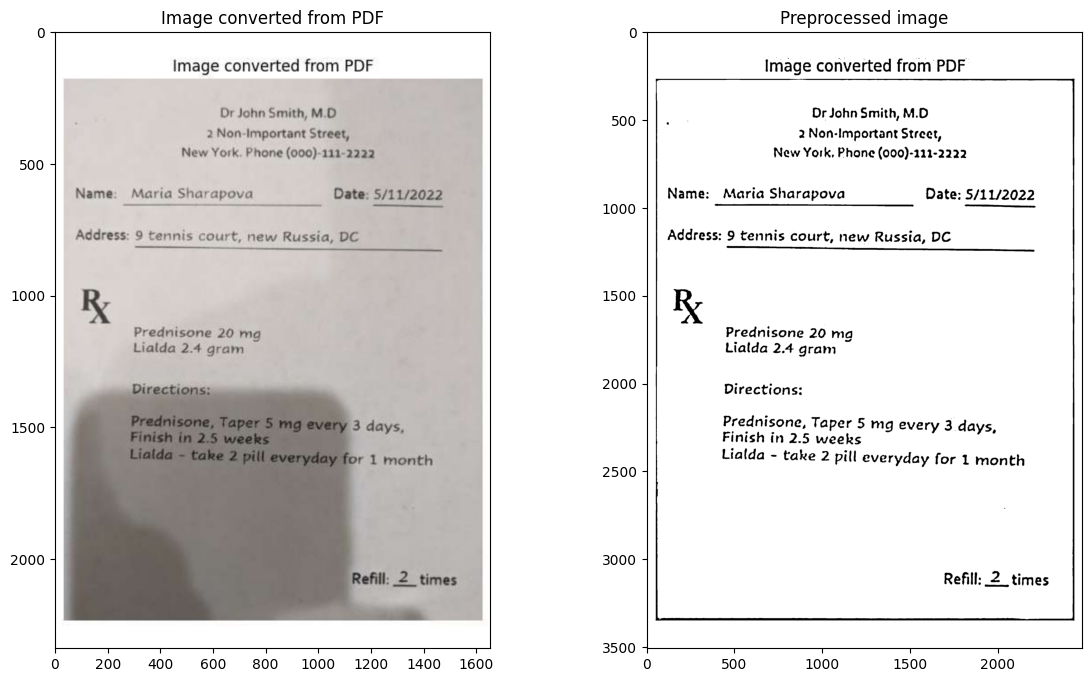

In [7]:
# Import required libraries
import pytesseract
from pdf2image import convert_from_path
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Define the preprocess_image function
def preprocess_image(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    processed_image = cv2.adaptiveThreshold(
        resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 12
    )
    return processed_image

# Applying preprocessing on image
img = preprocess_image(images[0]) # Use images[0] since images is a list

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.axis(True)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis(True)
plt.title("Preprocessed image")
plt.show()

In [8]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

Image converted from PDF

Or John Smith, M.O
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Maria Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

K

SS SSS

Prednisone 20 mg
Lialda 2.4 gram

Directions:
Prednisone, Taper 5 mg every 3 days,

Finish in 2.5 weeks
Lialda - take 2 pill everyday for 1 month

Refill: 2 times

 



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


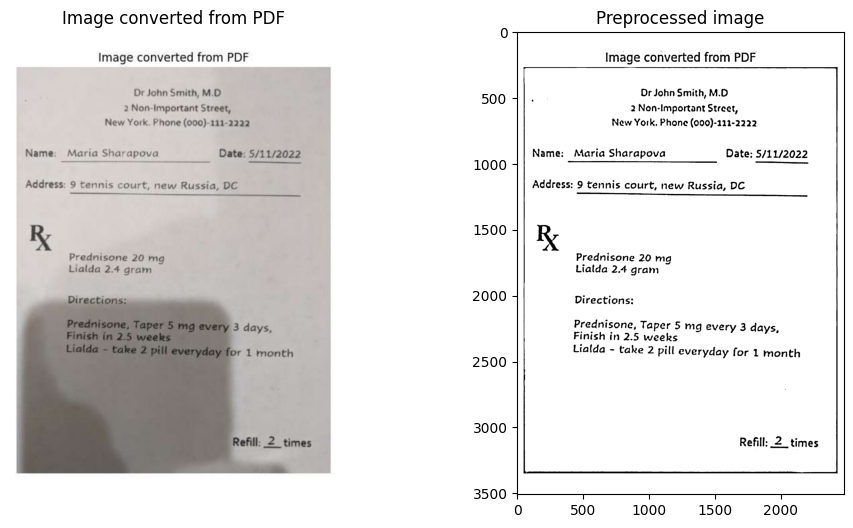

-----------------------------Text--------------------------------------
Image converted from PDF

Or John Smith, M.O
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Maria Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

K

SS SSS

Prednisone 20 mg
Lialda 2.4 gram

Directions:
Prednisone, Taper 5 mg every 3 days,

Finish in 2.5 weeks
Lialda - take 2 pill everyday for 1 month

Refill: 2 times

 



In [9]:
# Install Poppler on Linux (if not already installed)
!apt-get install poppler-utils

# Import necessary libraries
import pytesseract
from pdf2image import convert_from_path
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the preprocess_image function
def preprocess_image(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    processed_image = cv2.adaptiveThreshold(
        resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 63, 12
    )
    return processed_image

# Set the correct Poppler path for Linux
POPPLER_PATH = "/usr/bin"  # Adjust this if pdfinfo is in a different location

# Let's try extracting text from our second prescription
DOC_PATH_1 = r"/content/download.pdf"
# If the above path is still a Windows path, change it to the correct Linux path
pages_1 = convert_from_path(DOC_PATH_1, poppler_path=POPPLER_PATH)
img = preprocess_image(pages_1[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(pages_1[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()
print("-----------------------------Text--------------------------------------")
text_2 = pytesseract.image_to_string(img, lang="eng")
print(text_2)

In [12]:
# A function to return useful information in JSON format
def parse(text: str) -> Dict:
    return{
        "patient_name": get_field("patient_name", text),
        "patient_address": get_field("patient_address", text),
        "medicines": get_field("medicines", text),
        "directions": get_field("directions", text),
        "refill": get_field("refill", text)
    }

# A function to find useful information from our text using Regular Expressions
def get_field(field_name: str, text: str) -> str:
    pattern_dict = {
        "patient_name": {"pattern": "Name:(.*)Date", "flags": 0},
        "patient_address": {"pattern": "Address:(.*)\n", "flags": 0},
        "medicines": {"pattern": "Address:[^\n]*(.*)Directions", "flags": re.DOTALL},
        "directions": {"pattern": "Directions:.(.*)Refill", "flags": re.DOTALL},
        "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},
    }

    pattern_object = pattern_dict.get(field_name)
    if pattern_object:
        matches = re.findall(pattern_object["pattern"], text, flags=pattern_object["flags"])
        if len(matches) > 0:
            return matches[0].strip()

In [13]:
# Let's get useful fields from our texts
text_list = [text_1, text_2]
for i in range(len(text_list)):
    print(f"Important fields from text {i+1}:\n")
    print(parse(text_list[i]))
    print("\n----------------------\n")

Important fields from text 1:

{'patient_name': 'Maria Sharapova', 'patient_address': '9 tennis court, new Russia, DC', 'medicines': 'K\n\nSS SSS\n\nPrednisone 20 mg\nLialda 2.4 gram', 'directions': 'Prednisone, Taper 5 mg every 3 days,\n\nFinish in 2.5 weeks\nLialda - take 2 pill everyday for 1 month', 'refill': '2'}

----------------------

Important fields from text 2:

{'patient_name': 'Maria Sharapova', 'patient_address': '9 tennis court, new Russia, DC', 'medicines': 'K\n\nSS SSS\n\nPrednisone 20 mg\nLialda 2.4 gram', 'directions': 'Prednisone, Taper 5 mg every 3 days,\n\nFinish in 2.5 weeks\nLialda - take 2 pill everyday for 1 month', 'refill': '2'}

----------------------

